# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **classifiers/softmax.py**. 


In [74]:
# First implement the naive softmax loss function with nested loops.
# Open the file classifiers/softmax.py and implement the
# softmax_loss_naive function.

from classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.351839
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *10 classes with each approx 1/10 chances of being labeled by chance*


In [77]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

(626, 0)
numerical: -4.486762 analytic: -4.486763, relative error: 1.063280e-08
(302, 6)
numerical: 1.098631 analytic: 1.098631, relative error: 1.832210e-08
(733, 9)
numerical: -1.219422 analytic: -1.219422, relative error: 3.251936e-08
(2780, 7)
numerical: 0.585781 analytic: 0.585781, relative error: 2.326912e-07
(321, 9)
numerical: -1.132737 analytic: -1.132737, relative error: 3.646628e-08
(1092, 3)
numerical: 0.983917 analytic: 0.983917, relative error: 3.528954e-09
(969, 2)
numerical: 0.896732 analytic: 0.896732, relative error: 8.058496e-09
(661, 7)
numerical: 1.015357 analytic: 1.015357, relative error: 3.834599e-08
(2986, 2)
numerical: -0.597232 analytic: -0.597232, relative error: 5.363359e-08
(2841, 3)
numerical: -1.178502 analytic: -1.178502, relative error: 7.187749e-10
(2981, 9)
numerical: -1.049098 analytic: -1.049098, relative error: 1.309730e-07
(1660, 0)
numerical: -0.781469 analytic: -0.781469, relative error: 3.052324e-08
(2571, 5)
numerical: -1.565804 analytic: -1.

In [78]:
print grad.shape

(3073, 10)


In [103]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.351839e+00 computed in 0.293854s
vectorized loss: 2.351839e+00 computed in 0.015184s
Loss difference: 0.000000
Gradient difference: 0.000000


In [110]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
# learning_rates = [1e-7, 5e-7]
# regularization_strengths = [5e4, 1e8]

# learning_rates = [9e-7, 3e-7, 1e-7, 8e-6]
learning_rates = [x * 1e-7 for x in range(1, 10)]
# regularization_strengths = [1e4, 5e4, 3e4]
# regularization_strengths = [x * 1e4 for x in range(1, 10)]
regularization_strengths = [7e4, 8e4, 9e4, 1e5, 2e5, 3e5, 4e5]
num_iters = 1500

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# for lr, rg in learning_rates, regularization_strengths:
for lr in learning_rates:
    for rg in regularization_strengths:
        softm = Softmax()
        loss_hist = softm.train(X_train, y_train, learning_rate=lr, reg=rg,
                      num_iters=num_iters, verbose=False)
        y_train_pred = softm.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = softm.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        results[(lr, rg)] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_softmax = softm

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

lr 1.000000e-07 reg 7.000000e+04 train accuracy: 0.320367 val accuracy: 0.334000
lr 1.000000e-07 reg 8.000000e+04 train accuracy: 0.309082 val accuracy: 0.328000
lr 1.000000e-07 reg 9.000000e+04 train accuracy: 0.313551 val accuracy: 0.328000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.306816 val accuracy: 0.323000
lr 1.000000e-07 reg 2.000000e+05 train accuracy: 0.287143 val accuracy: 0.305000
lr 1.000000e-07 reg 3.000000e+05 train accuracy: 0.288653 val accuracy: 0.298000
lr 1.000000e-07 reg 4.000000e+05 train accuracy: 0.278633 val accuracy: 0.296000
lr 2.000000e-07 reg 7.000000e+04 train accuracy: 0.308673 val accuracy: 0.325000
lr 2.000000e-07 reg 8.000000e+04 train accuracy: 0.311041 val accuracy: 0.323000
lr 2.000000e-07 reg 9.000000e+04 train accuracy: 0.300347 val accuracy: 0.322000
lr 2.000000e-07 reg 1.000000e+05 train accuracy: 0.308347 val accuracy: 0.327000
lr 2.000000e-07 reg 2.000000e+05 train accuracy: 0.282224 val accuracy: 0.290000
lr 2.000000e-07 reg 3.000000

In [111]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.328000


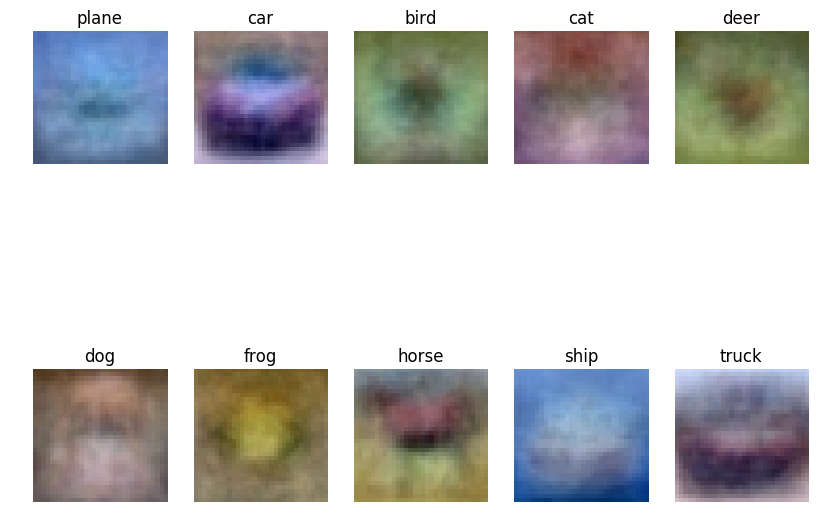

In [112]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])